In [ ]:
!pip install scanpy squidpy --quiet
!pip install scikit-misc

ERROR: Could not find a version that satisfies the requirement SpatialDE2 (from versions: none)
ERROR: No matching distribution found for SpatialDE2


In [ ]:
# Import of libraries for working with spatial transcriptomics data
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os
import squidpy as sq
from matplotlib.colors import ListedColormap
import argparse

/usr/lib/python3.12/importlib/__init__.py:90: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  return _bootstrap._gcd_import(name[level:], package, level)
/usr/local/lib/python3.12/dist-packages/squidpy/gr/_utils.py:23: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  CAN_USE_SPARSE_ARRAY = Version(anndata.__version__) >= Version("0.11.0rc1")
/usr/local/lib/python3.12/dist-packages/anndata/__init__.py:70: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  return module_get_attr_redirect(attr_name, deprecated_mapping=_DEPRECATED)


##Loading data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data_path = "/content/drive/Shareddrives/Spatial_Transcriptomics/data_after_qc/SN048_A121573_Rep1/adata_QC_filtered.normalized.h5ad"

print("Loading dataset...")

# The read_visium function automatically detects the folder containing 'filtered_feature_bc_matrix' and 'spatial'
# Load Visium (10x Genomics) data into an AnnData object
adata_qc = sc.read_h5ad(data_path)
print("Dataset loaded.")

Loading dataset...
Dataset loaded.


/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1798: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


#2.3 Selecting genes

## 2.3.1 Highly Variable Genes (HVGs)

The mitochondrial genes are too highly expressed and are not of major biological interest.

In [ ]:
adata_HVG = adata_qc[:, ~adata_qc.var_names.str.startswith('MT-')].copy()

In [ ]:
# This step models the mean–variance relationship of log-expression values
sc.pp.highly_variable_genes(
    adata_HVG,
    flavor="seurat_v3",   # modern and robust method similar to scran
    span=0.3
)

/usr/local/lib/python3.12/dist-packages/legacy_api_wrap/__init__.py:88: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  return fn(*args_all, **kw)


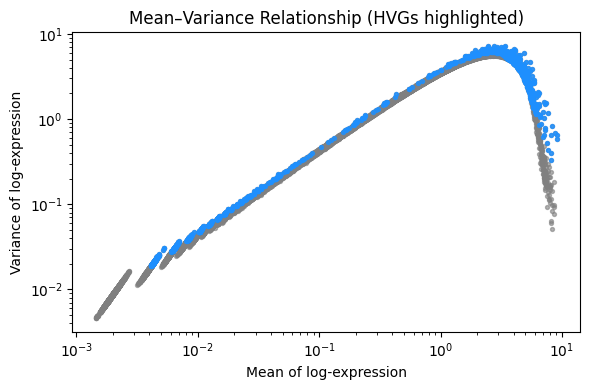

In [ ]:
# Visualize mean–variance relationship
hv_df = pd.DataFrame({
    "mean": adata_HVG.var["means"],
    "variance": adata_HVG.var["variances"],
    "highly_variable": adata_HVG.var["highly_variable"]
})

plt.figure(figsize=(6, 4))
# Plot all genes in gray
plt.scatter(hv_df["mean"], hv_df["variance"], s=8, color="grey", alpha=0.6)
# Highlight highly variable genes in blue
plt.scatter(
    hv_df.loc[hv_df["highly_variable"], "mean"],
    hv_df.loc[hv_df["highly_variable"], "variance"],
    s=8, color="dodgerblue", alpha=0.8
)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Mean of log-expression")
plt.ylabel("Variance of log-expression")
plt.title("Mean–Variance Relationship (HVGs highlighted)")
plt.tight_layout()
plt.show()

In [ ]:
# Select top 10% highly variable genes (like prop=0.1 in R)
prop = 0.1
n_top = int(len(adata_HVG.var_names) * prop)
top_hvgs = adata_HVG.var_names[adata_HVG.var["highly_variable_rank"] <= n_top]  #???not sure, if by highly_variable_rank

print(f"Number of top HVGs: {len(top_hvgs)}, where we wanted top {prop*100}%, which is maximum {n_top} genes")

Number of top HVGs: 2000, where we wanted top 10.0%, which is maximum 3658 genes
